# NLP track project


The goal of this project is to guide you through the latest techniques in NLP, we have chosen to frame that journey around the problem of *Machine Translation*, More specifically english-spanish translation. 

The motivation for centering around this particular problem is that it's a complex one that has been revolutionized lately. So It will guide you from the basics to the latest SOA techniques.

The reason we choose English and Spanish is purely because we happen to know both of them, if you would like to explore other language feel free to do so but make sure you have a proper dataset that you can use.

## 1. Baseline

As a baseline we will first train a simple encoder-decoder architecture. The code is based on the [seq2seq notebook](https://github.com/fastai/course-nlp/blob/master/7-seq2seq-translation.ipynb) from the [lesson 12](https://www.youtube.com/watch?v=IfsjMg4fLWQ&list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9&index=13&t=0s) of the Fast.ai's NLP course.

### 1.1 Dataset

The dataset we will use was build by [Open Subtitles](https://www.opensubtitles.org/) and consists of movie and series subtitles, we chose this dataset over the alternatives because it contains casual and more simple language than the alternatives (UN resolutions, EU parlament sessions, etc). You can look at the alternatives on this [amazing site](http://opus.nlpl.eu/).

Unfurtunately the spanish used is from Spain, not sure why the Latin American version of the subtitles is not available.

The dataset is extremely large and not in a great format, you can see how we processed it on [this notebook](./subtitles-download.ipynb). There is no need to run it, the resulting csv should be available in [???]

In [1]:
import pandas as pd

df = pd.read_csv('subtitles.csv')

/home/javiber/.local/share/virtualenvs/javiber-jarMRqt3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
print(len(df))
df.sample(5)

7990657


,files,sub_id,en,es
4683972,en/2013/2450744/4863403.xml#es/2013/2450744/48...,512,You 're Malcolm 's new hero .,Eres el nuevo héroe de Malcolm .
845013,en/2000/216800/215763.xml#es/2000/216800/57166...,685,Good ... and you ?,"Bien , ¿ y a ti ?"
4505119,en/2012/2555708/5582609.xml#es/2012/2555708/58...,141,"Come on , now , is that a donut or what ?","Vamos , ahora , es ¿ Que una dona o qué ?"
570567,en/1990/99348/5628189.xml#es/1990/99348/400608...,278,It is for a girl .,Para una chica .
3977199,en/2012/2174327/4499006.xml#es/2012/2174327/61...,196,So you 're watching him ?,¿ Entonces le estás vigilando ?


In [3]:
df.isna().sum()

files     0
sub_id    0
en        8
es        6
dtype: int64

In [4]:
df.dropna(inplace=True)
df.isna().sum()

files     0
sub_id    0
en        0
es        0
dtype: int64

In [4]:
df = df.sample(50000, random_state=42)

### 1.2 Tokenization and Numericalization

Unfurtunately the dataset was already tokenized, that's why you see spaces around punctuation marks. Not a big deal but we'd have rather the raw messages.

Anyway for this baseline we will use the default settings from fast.ai which is to use spaCy's tokenizer.

In [1]:
from fastai.text import *

#### 1.2.1 Data collate

In order to run the RNN in parallel for a whole batch, all examples in a batch must have the same size. 
To accomplish this we'll add padding where necessary.

In [4]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x = max([len(s[0]) for s in samples])
    max_len_y = max([len(s[1]) for s in samples])
    
    # create matrices of the target size we want (batch_lenght x max_sentence_lenght_in_batch) full of padding
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    
    if backwards: 
        pad_first = not pad_first
    
    for i, s in enumerate(samples):
        # replace the part of the correct part of the padded matrices with the actual values
        if pad_first: 
            res_x[i, -len(s[0]):] = LongTensor(s[0])
            res_y[i, -len(s[1]):] = LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):] = LongTensor(s[0])
            res_y[i,:len(s[1]):] = LongTensor(s[1])
            
    if backwards: 
        res_x,res_y = res_x.flip(1),res_y.flip(1)
    
    return res_x,res_y

#### 1.2.2 Custom databunch

On the training set, we don't want to mix really long senteces with really short because that'd create lots of padding, instead we'll use fast.ai's `SortishSampler` to keep the sentences of a batch relatively the same size while also having some randomization.

In [5]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    
    @classmethod
    def create(
            cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
           dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
            **dl_kwargs) -> DataBunch:
        """
        Function that transform the `datasets` in a `DataBunch` for classification. 
        Passes `**dl_kwargs` on to `DataLoader()`
        """
        
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = bs if val_bs is None else val_bs 
        
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        
        # Sample data randomly but trying to keep the lenghts similar
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
            
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)
    
    
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [8]:
path = Path.home()/'open_subtitles'

src = (Seq2SeqTextList
       .from_df(df, path=path, cols='en')
       .split_by_rand_pct(seed=42)
       .label_from_df(cols='es', label_cls=TextList))

#### 1.2.3 Analyze sentence length
Some sentences are extremely large so we will remove those outliers

In [9]:
x_lengths = [len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items]
np.percentile(x_lengths, 90), np.max(x_lengths)

(18.0, 81)

In [10]:
y_lengths = [len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items]
np.percentile(y_lengths, 90), np.max(y_lengths)

(17.0, 65)

In [11]:
src = src.filter_by_func(lambda x,y: len(x) > 10 or len(y) > 20)

In [12]:
len(src.train) + len(src.valid)

30112

#### 1.2.4 View results

In [3]:
bs = 128

In [14]:
data = src.databunch(bs=bs)


In [15]:
data.show_batch()

text,target
"xxbos xxmaj no , no , no , no !","xxbos xxmaj no , no , no , no !"
xxbos - xxmaj they 'll be at the xxunk .,xxbos - xxmaj estarán en el refugio .
xxbos xxmaj are you gon na dance or what ?,xxbos xxmaj vas a bailar o que ?
xxbos i ' m happy to . xxmaj okay .,xxbos xxmaj estoy feliz de ayudar .
"xxbos xxmaj ah , my fiancée princess xxmaj xxunk .","xxbos xxmaj ah , mi prometida la princesa xxmaj xxunk ."


**TODO:** how does fastai know which tokenizer to use? is it using english tokenizer on spanish?

In [16]:
data.save()

#### 1.2.4 Load saved databunch

In [6]:
path = Path.home()/'open_subtitles'
data = load_data(path, bs=bs)

### 1.3 Embeddings

We will use the embedings from [fastText](https://fasttext.cc/docs/en/support.html) because they have pretrained models that are good enough for our baseline.

#### 1.3.1 Download pretrained word vectors

In [ ]:
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -P {path}
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.bin.gz -P {path}

In [ ]:
# ! gunzip {path}/cc.en.300.bin.gz
# ! gunzip {path}/cc.es.300.bin.gz

In [17]:
import fasttext as ft

In [18]:
es_vecs = ft.load_model(str((path/'cc.es.300.bin')))
en_vecs = ft.load_model(str((path/'cc.en.300.bin')))

In [19]:
def create_emb(vecs, itos, em_sz=300, mult=1.):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    vec_dic = {w: vecs.get_word_vector(w) for w in vecs.get_words()}
    miss = 0
    for i, w in enumerate(itos):
        try: 
            wgts[i] = tensor(vec_dic[w])
        except: 
            miss += 1
    print(f'{miss} missing words')
    return emb

emb_enc = create_emb(en_vecs, data.x.vocab.itos)
emb_dec = create_emb(es_vecs, data.y.vocab.itos)

emb_enc.weight.size(), emb_dec.weight.size()

29 missing words
42 missing words


(torch.Size([5808, 300]), torch.Size([7016, 300]))

**NOTE**: the words in our vocabulary that are missing on the fasText's one will be set to random vectors

In [20]:
torch.save(emb_enc, path/'en_emb.pth')
torch.save(emb_dec, path/'es_emb.pth')

#### 1.3.2 Load saved embeddings

In [7]:
emb_enc = torch.load(path/'en_emb.pth')
emb_dec = torch.load(path/'es_emb.pth')

### 1.4 Model

The Model we will use is the classic Encoder-Decoder, using a GRU to encode the meaning of the sentence in the original language into a fixed-size vector that the decode will convert into the target language, hopefully conservint the meaning.

In [26]:
%%HTML
<video alt="test" width="900" autoplay loop>
    <source src="https://jalammar.github.io/images/seq2seq_3.mp4" type="video/mp4">
</video>
<center>Video from Jay Alammar's <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">seq2seq post</a><center/>

In [10]:
class EncDecRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        
        self.nl, self.nh, self.out_sl = nl, nh, out_sl
        self.bos_idx, self.pad_idx = bos_idx, pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(
            self.em_sz_enc, nh, num_layers=nl, dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(
            self.em_sz_dec, self.em_sz_dec, num_layers=nl, dropout=0.1, batch_first=True)
        
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
        self.tf_weight = 0  # teacher forcing weight
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return outp, h
        
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
            outp, h = self.decoder(dec_inp, h)
            dec_inp = outp.max(1)[1]
            res.append(outp)
            if (dec_inp==self.pad_idx).all(): 
                break
                
            # Teacher forcing
            if (targ is not None) and (random.random() < self.tf_weight):
                if i>=targ.shape[1]: continue
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs): 
        return one_param(self).new_zeros(self.nl, bs, self.nh)

In [11]:
xb, yb = next(iter(data.valid_dl))
xb.shape

torch.Size([128, 10])

In [12]:
rnn = EncDecRNN(emb_enc, emb_dec, 256, 20)
rnn

EncDecRNN(
  (emb_enc): Embedding(5808, 300, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15)
  (gru_enc): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.25)
  (out_enc): Linear(in_features=256, out_features=300, bias=False)
  (emb_dec): Embedding(7016, 300, padding_idx=1)
  (gru_dec): GRU(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (out_drop): Dropout(p=0.35)
  (out): Linear(in_features=300, out_features=7016, bias=True)
)

In [21]:
class TeacherForcing(LearnerCallback):
    "Callback used to redice tf_weight on each epoch"
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.tf_weight = max(1 - epoch/self.end_epoch, 0)
        
class TF_metric(Callback):
    "Callback to print teacher forcing weight during training"
    def __init__(self, model):
        self.name = 'tf_weight'
        self.model = model
        
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, self.model.tf_weight)

### 1.6 Metrics and loss functions

#### 1.6.1 Cross-Entropy loss

In [16]:
def cross_entropy(out, targ, pad_idx=1):
    bs, targ_len = targ.size()
    _, out_len, vs = out.size()
    if targ_len > out_len: 
        out  = F.pad(out, (0, 0, 0, targ_len - out_len, 0, 0), value=pad_idx)
    if out_len > targ_len: 
        targ = F.pad(targ, (0, out_len - targ_len, 0, 0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

#### 1.6.2 Token-level accuracy 

In [19]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

#### 1.6.3 BLEU

In [14]:
class NGram():
    def __init__(self, ngram, max_n=5000): 
        self.ngram,self.max_n = ngram,max_n
        
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): 
            return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    
    def __hash__(self): 
        return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams, targ_grams = get_grams(pred, n, max_n=max_n), get_grams(targ, n, max_n=max_n)
    pred_cnt, targ_cnt = Counter(pred_grams), Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g, c in pred_cnt.items()]), len(pred_grams)

class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len, self.targ_len, self.corrects, self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred, targ in zip(last_output.cpu().numpy(), last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c, t = get_correct_ngrams(pred, targ, i + 1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

### 1.5 Training

In [22]:
learn = Learner(
    data, rnn, loss_func=cross_entropy, 
    metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos)), TF_metric(rnn)], 
    callback_fns=partial(TeacherForcing, end_epoch=2))

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


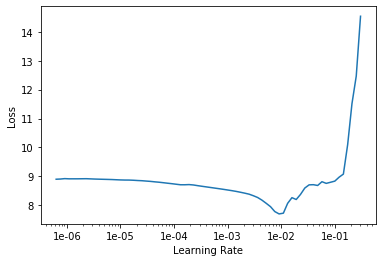

In [31]:
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,tf_weight,time
0,2.310207,3.215026,0.590341,0.420931,1.000000,00:12
1,2.147947,3.030729,0.544406,0.406101,0.500000,00:10
2,2.914343,3.287255,0.512942,0.354443,0.000000,00:10
3,2.413641,3.029603,0.546262,0.378552,0,00:10


In [40]:
learn.save('baseline')

#### 1.5.1 Load the model

In [24]:
learn.load('baseline');

### TODO: a note on bleu

### 1.6 Cualitative evaluation

In [25]:
# put the model on evaluation mode
learn.model.eval();

In [29]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    "returns predictions and non-reconstructed activations"
    ds = learn.data.train_ds
    rxs, rys, rzs, xs, ys, zs = [],[],[],[],[],[]
    
    with torch.no_grad():
        for xb, yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x,y,z in zip(xb,yb,out):
                rxs.append(ds.x.reconstruct(x))
                rys.append(ds.y.reconstruct(y))
                preds = z.argmax(1)
                rzs.append(ds.y.reconstruct(preds))
                for a,b in zip([xs,ys,zs],[x,y,z]): a.append(b)
    return rxs,rys,rzs,xs,ys,zs

rxs, rys, rzs, xs, ys, zs = get_predictions(learn)

#### 1.6.1 Nucleus

We will analyze the output using the our basic prediction of the most likely word and nucleus wich will pick a word from a set of likely words.

In [35]:
from random import choice

def select_nucleus(outp, p=0.5):
    probs = F.softmax(outp,dim=-1)
    idxs = torch.argsort(probs, descending=True)
    res,cumsum = [],0.
    for idx in idxs:
        res.append(idx)
        cumsum += probs[idx]
        if cumsum>p: return idxs.new_tensor([choice(res)])

def decode_with_nucleus(self, inp, targ=None):
    inp = inp[None]
    bs, sl = inp.size()
    h = self.encoder(bs, inp)
    dec_inp = inp.new_zeros(bs).long() + self.bos_idx

    res = []
    for i in range(self.out_sl):
        outp, h = self.decoder(dec_inp, h)
        dec_inp = select_nucleus(outp[0], p=0.3)
        
        res.append(dec_inp)
        if (dec_inp==self.pad_idx).all(): 
            break

        # Teacher forcing
        if (targ is not None) and (random.random() < self.tr_weight):
            if i>=targ.shape[1]: continue
            dec_inp = targ[:,i]
    return torch.stack(res)

def predict_with_nucleus(learn, x, y):
    ds = learn.data.train_ds
    with torch.no_grad():
        out = decode_with_nucleus(learn.model, x)
        rx = ds.x.reconstruct(x)
        ry = ds.y.reconstruct(y)
        rz = ds.y.reconstruct(out.squeeze())
    return rx,ry,rz

In [43]:
for _ in range(10):
    i = np.random.randint(0, len(inputs))
    print(rxs[i])
    print(rzs[i])
    _, _, nucleus_prediction = predict_with_nucleus(learn, xs[i], ys[i])
    print(nucleus_prediction)
    print('~'*20)

xxbos xxmaj he will be xxunk in due time .
xxbos xxmaj se se en en tiempo . .
xxbos xxmaj se ha a de de . .
~~~~~~~~~~~~~~~~~~~~
xxbos i ' ve been xxunk .
xxbos xxmaj he estado xxunk . .
xxbos xxmaj he estado de . .
~~~~~~~~~~~~~~~~~~~~
xxbos xxmaj oh stop it !
xxbos ¡ xxmaj oh !
xxbos ¡ xxmaj ! !
~~~~~~~~~~~~~~~~~~~~
xxbos i don ' t hold breath .
xxbos xxmaj no me xxunk .
xxbos xxmaj no entiendo un .
~~~~~~~~~~~~~~~~~~~~
xxbos xxmaj xxunk the xxunk xxmaj xxunk .
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk
~~~~~~~~~~~~~~~~~~~~
xxbos xxmaj someone else killed xxmaj kim xxmaj xxunk .
xxbos xxmaj alguien alguien a xxmaj xxmaj xxmaj .
xxbos xxmaj alguien a xxmaj xxunk xxmaj xxmaj .
~~~~~~~~~~~~~~~~~~~~
xxbos xxmaj denied each time .
xxbos xxmaj se a tiempo .
xxbos xxmaj se al . .
~~~~~~~~~~~~~~~~~~~~
xxbos i ' m in love with her .
xxbos xxmaj estoy voy con ella .
xxbos xxmaj estoy en a su
~~~~~~~~~~~~~~~~~~~~
xxbos ! let me in !
xxbos ¡ xxmaj xxunk !

A lot of different things can be tried to improve this baseline but we don't want to loose too much time on it, some ideas that could be incorporated here are:

- better predictions with [beam search](https://en.wikipedia.org/wiki/Beam_search)
- align batches in a way that allows us to keep h between them? similar to what is done in [notebook 6](https://github.com/fastai/course-nlp/blob/master/6-rnn-english-numbers.ipynb) of fast.ai's course
- Handle UNK better using a sub-word tokenizer like [BPT](https://github.com/rsennrich/subword-nmt) or [SentencePiece](https://github.com/google/sentencepiece)
- train with the full dataset

## Exploring alternatives

Now that we have a basic understanding of the problem we will dive into more novel solutions. On this section is I'll enumerate different alternatives and pick one to try, I encourage you to choose a different one so that we can compare results later.

## 1. Tokenizer and embedding 

FastText was OK for our baseline but there are much better embedings that we can choose, here are the most important ones:

- UMLFit
- ELMO
- BERT
- *Other?* - NLP is in the middle of a revolution, keep an eye on the latest news.

Training one of these more advanced models from scratch is quite lengthy and it might not be possible on the available hardware we have. As a reference, I trained UMLFit from scratch on the whole wikipedia in spanish on a 2080 Ti with 11GB and took ~25hrs ([notebook](./nn-spanish.ipynb)).

For this reason I highly recommend using pre-trained models where possible (for english there are pre-trained weights available for all models but for spanish there might not be available).

## 2. UMLFit with transformers

I will use the embeddings from [ULMFit](https://arxiv.org/pdf/1801.06146.pdf) because I have pretrained models for both languages. As for the model I'll replace our RNN-based encoder-decoder with a [transformer](https://arxiv.org/pdf/1706.03762.pdf) 

### 2.1 English embeddings

We will start with ULMFit's pre-trained model for english and fin-tuned it on our subtitles

In [1]:
from fastai.text import *

In [2]:
path = Path.home()/'open_subtitles'

In [47]:
df = pd.read_csv('subtitles.csv')
df.dropna(inplace=True)

/home/javiber/.local/share/virtualenvs/javiber-jarMRqt3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [49]:
data_lm = (TextList.from_df(df, path=path, cols='en')
            .split_by_rand_pct(0.1, seed=42)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs, num_workers=12))

In [52]:
data_lm.save('lm_en')

In [3]:
data_lm = load_data(path/'lm_en', bs=48)

In [4]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=1.0)

In [5]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


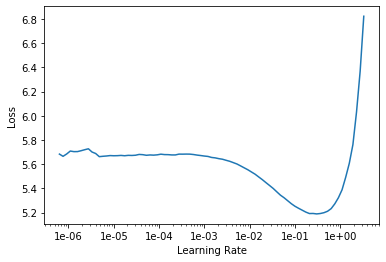

In [7]:
learn_lm.recorder.plot()

In [9]:
learn_lm.fit_one_cycle(2, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [ ]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr, moms=(0.8,0.7))

In [ ]:
learn_lm.save(f'en_fine_tuned')
learn_lm.save_encoder(f'en_fine_tuned_enc')

### 2.1 Spanish embeddings

We do the same for spanish, in this case the pre-trained spanish LM was trained by me on [this notebook](./nn-spanish.ipynb)

In [ ]:
data_lm_es = (TextList.from_df(df, path=path, cols='es')
            .split_by_rand_pct(0.1, seed=42)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs, num_workers=12))

In [ ]:
learn_lm_es = language_model_learner(data_lm_es, AWD_LSTM, pretrained_fnames=[f'es_wt', f'es_wt_vocab'], drop_mult=1.0)